## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

/home/k64835/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/k64835/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10t', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10t', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 12, 64, 64]), torch.Size([48, 7, 12, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [5]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [6]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

In [7]:
# train_tensor, test_tensor, train_field_numbers, test_field_numbers = train_test_split(
#     patch_tensor_train, field_numbers_train, test_size=1-config.ae_train_test_ratio, random_state=42
# )

# dataloader_train = create_data_loader(train_tensor, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
# dataloader_test = create_data_loader(test_tensor, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
# dataloader_eval = create_data_loader(patch_tensor_eval, field_numbers_eval, batch_size=config.ae_batch_size, shuffle=False)

### Create Sub-Patches

In [8]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([54623, 7, 12, 4, 4]), torch.Size([1197, 7, 12, 4, 4]))

Get field numbers and co-ordinates as string

In [9]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_24_28'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [10]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Architecture: Conv3D Autoencoder with Temporal Encodings

### Architecture

Input Data: ( N x C x D x H x W )

In [33]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [35]:
device = 'cuda'
epochs = 50
lr = 0.01
momentum = 0.8
latent_dim = 32
channels = 12
time_steps = 7
optimizer = 'SGD'
weight_decay = 0.01
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(12, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [36]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, weight_decay=weight_decay, device=device)

Time taken per epoch: 10.2977 seconds
Epoch 1/50, Train Loss: 0.023480, Test Loss: 0.010522
Time taken per epoch: 10.5924 seconds
Epoch 2/50, Train Loss: 0.006856, Test Loss: 0.005149
Time taken per epoch: 10.2857 seconds
Epoch 3/50, Train Loss: 0.004729, Test Loss: 0.004410
Time taken per epoch: 10.1865 seconds
Epoch 4/50, Train Loss: 0.004213, Test Loss: 0.004042
Time taken per epoch: 10.3314 seconds
Epoch 5/50, Train Loss: 0.003930, Test Loss: 0.003829
Time taken per epoch: 10.2558 seconds
Epoch 6/50, Train Loss: 0.003767, Test Loss: 0.003705
Time taken per epoch: 10.3518 seconds
Epoch 7/50, Train Loss: 0.003669, Test Loss: 0.003630
Time taken per epoch: 10.3123 seconds
Epoch 8/50, Train Loss: 0.003609, Test Loss: 0.003581
Time taken per epoch: 10.3114 seconds
Epoch 9/50, Train Loss: 0.003568, Test Loss: 0.003547
Time taken per epoch: 10.2695 seconds
Epoch 10/50, Train Loss: 0.003539, Test Loss: 0.003524
Time taken per epoch: 10.2551 seconds
Epoch 11/50, Train Loss: 0.003519, Test L

### Evaluation

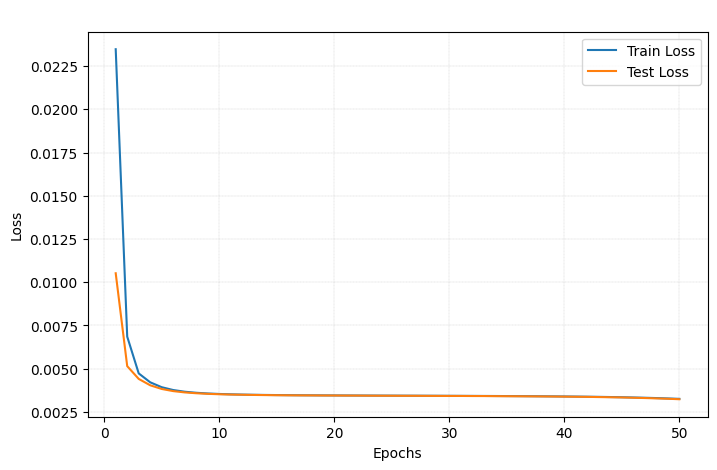

In [37]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

Load Saved Model to skip Training

In [15]:
# with open(config.kmeans_ae_3D_TE_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [16]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3d_TE_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [17]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [18]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=25)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [19]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 50.82
Precision: 54.72
Recall: 82.86
F1-score: 65.91
F2-score: 75.13


Assign field labels to training data for creating final visualisation images

In [326]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, config.subpatch_to_patch_threshold) #for box drawing

Save Models

In [327]:
# with open(config.ae_3d_TE_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [328]:
# with open(config.kmeans_ae_3D_TE_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

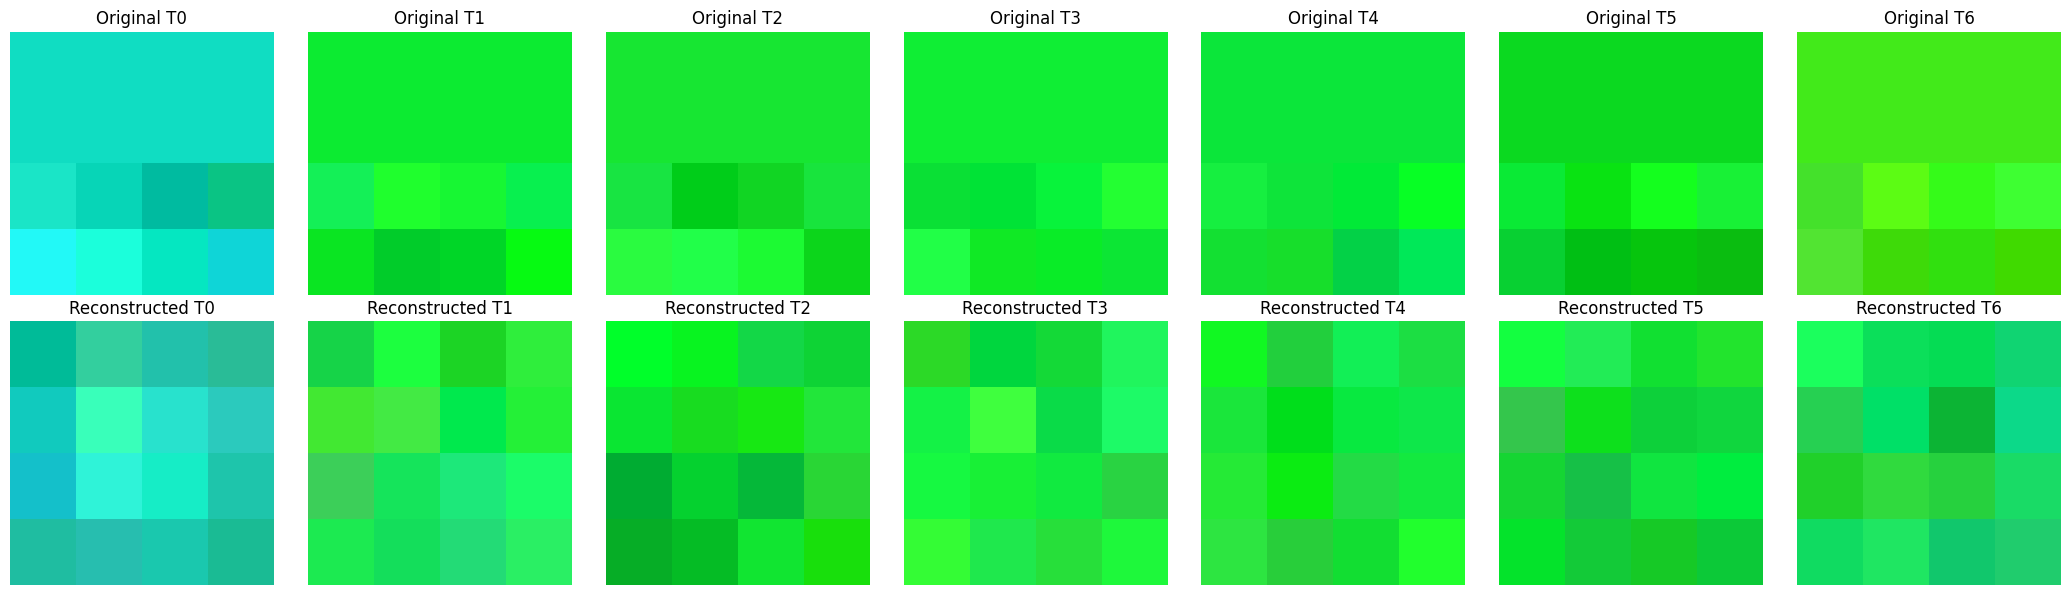

In [373]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

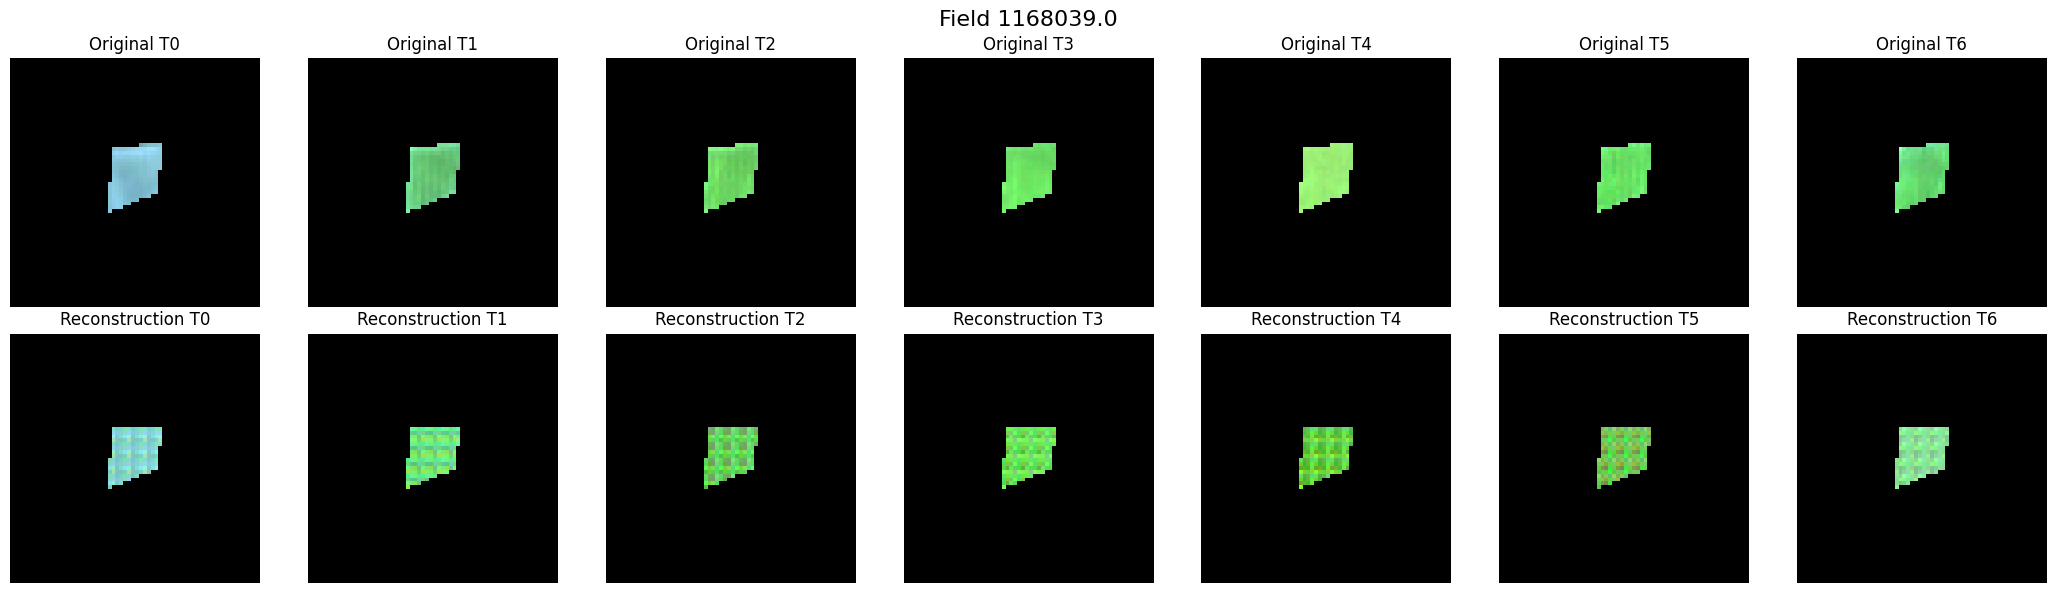

In [287]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device)

## Final Images: Visualising Diseased Subpatches

In [374]:
eval_images_box = images_visualisation_eval

In [375]:
(eval_images_box[0][0].shape)

(64, 64, 12)

In [376]:
np.unique(eval_images_box[0][0][:,:,-2])

array([0.70156171])

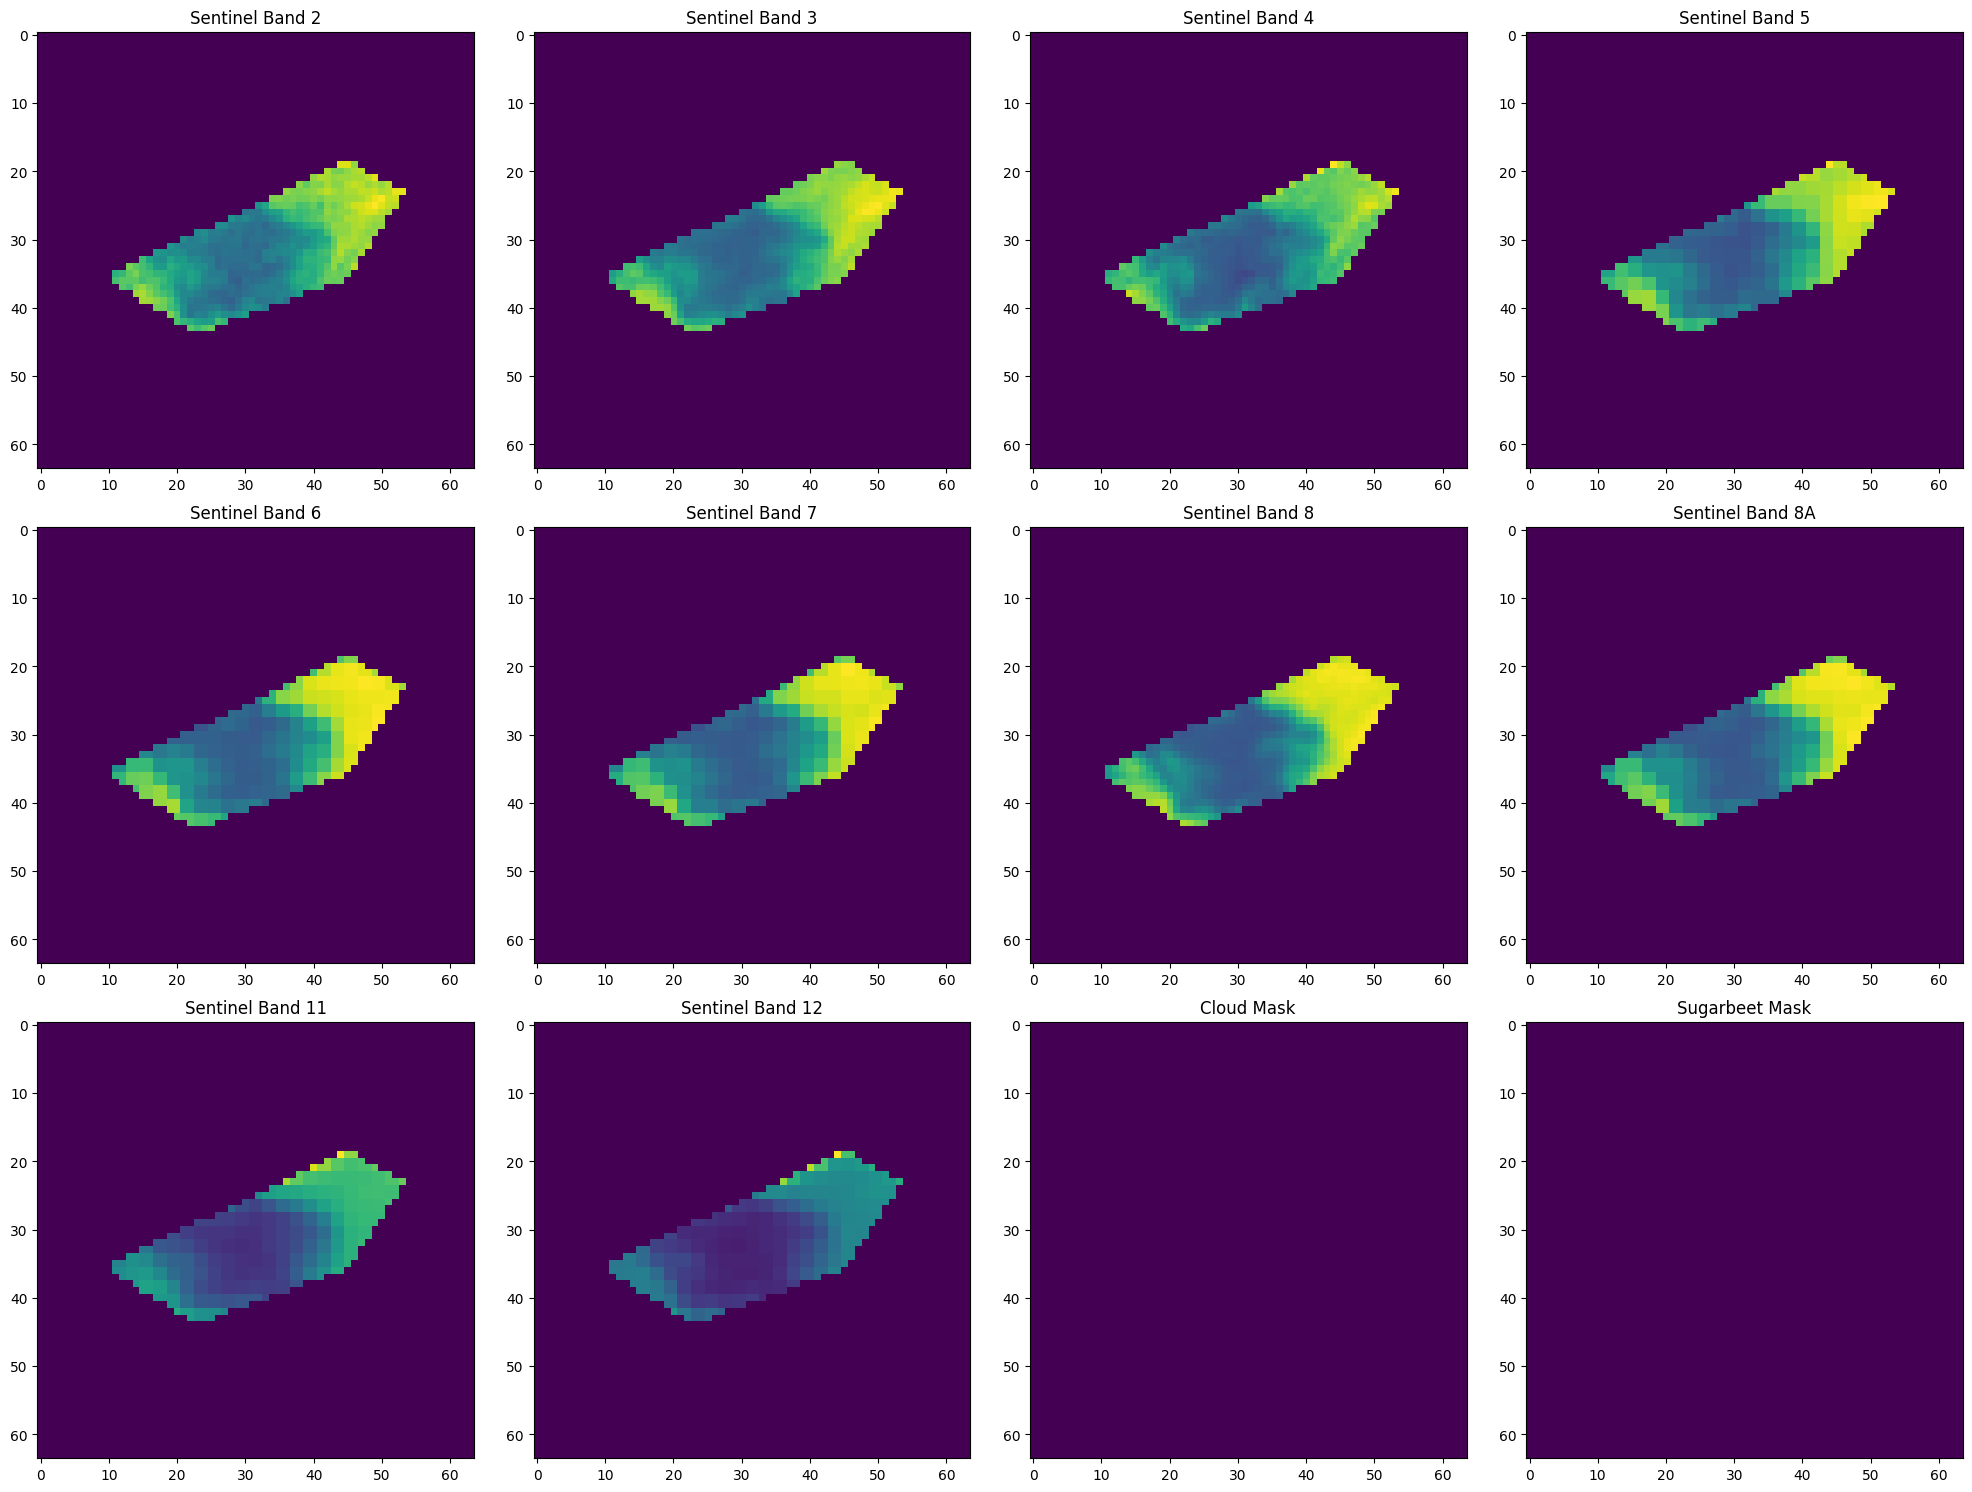

In [377]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

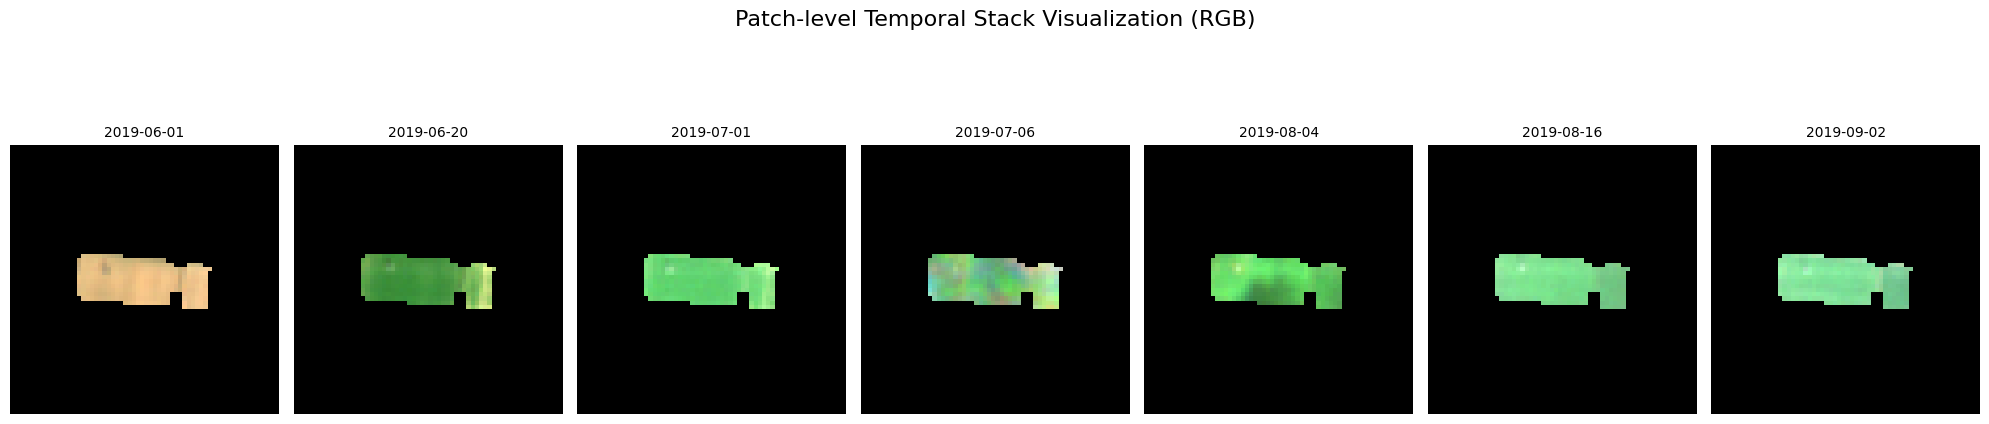

In [380]:
visualize_temporal_stack_rgb(eval_images_box[-26],acquisition_dates_eval[-26])

In [381]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([0.9633448])

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)